In [1]:
%matplotlib inline

In [2]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import os
import cv2

2024-04-16 18:44:31.189476: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-16 18:44:31.189682: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-16 18:44:31.252933: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-16 18:44:32.505079: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
n_epochs = 5   # Number of optimization epochs
n_layers = 1    # Number of random layers
n_train = 0    # Size of the train dataset
n_test = 0     # Size of the test dataset

SAVE_PATH = "qcnn"  # Data saving folder
PREPROCESS = True           # If False, skip quantum processing and load data from SAVE_PATH
np.random.seed(0)           # Seed for NumPy random number generator
tf.random.set_seed(0)       # Seed for TensorFlow random number generator

In [4]:
train_path="qcnn/train"
test_path="qcnn/test"
train_img=[]
train_lbl=[]
n_train=0
n_test=0
for folder in os.listdir(train_path):
    sub_path=train_path+"/"+folder
    for img in os.listdir(sub_path):
        n_train+=1
        image_path=sub_path+"/"+img
        img_arr=cv2.imread(image_path)
        img_arr=cv2.resize(img_arr,(224,224))
        train_img.append(img_arr)
        train_lbl.append(0 if folder=='Covid' else (1 if folder=='Normal' else 2))
test_img=[]
test_lbl=[]
for folder in os.listdir(test_path):
    sub_path=test_path+"/"+folder
    for img in os.listdir(sub_path):
        n_test+=1
        image_path=sub_path+"/"+img
        img_arr=cv2.imread(image_path)
        img_arr=cv2.resize(img_arr,(224,224))
        test_img.append(img_arr)
        test_lbl.append(0 if folder=='Covid' else 1 if folder=='Normal' else 2)
train_images = np.array(train_img)
train_labels = np.array(train_lbl)
test_images = np.array(test_img)
test_labels = np.array(test_lbl)

In [11]:

# Normalize pixel values within 0 and 1
train_images = train_images / 255
test_images = test_images / 255

# Add extra dimension for convolution channels
train_images = np.array(train_images[..., tf.newaxis], requires_grad=False)
test_images = np.array(test_images[..., tf.newaxis], requires_grad=False)

In [12]:
dev = qml.device("default.qubit", wires=4)
# Random circuit parameters
rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, 4))

@qml.qnode(dev)
def circuit(phi):
    # Encoding of 4 classical input values
    for j in range(4):
        qml.RY(np.pi * phi[j], wires=j)

    # Random quantum circuit
    RandomLayers(rand_params, wires=list(range(4)))

    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(4)]

In [13]:
def quanv(image):
    """Convolves the input image with many applications of the same quantum circuit."""
    out = np.zeros((14, 14, 4))

    # Loop over the coordinates of the top-left pixel of 2X2 squares
    for j in range(0, 28, 2):
        for k in range(0, 28, 2):
            # Process a squared 2x2 region of the image with a quantum circuit
            q_results = circuit(
                [
                    image[j, k, 0],
                    image[j, k + 1, 0],
                    image[j + 1, k, 0],
                    image[j + 1, k + 1, 0]
                ]
            )
            # Assign expectation values to different channels of the output pixel (j/2, k/2)
            for c in range(4):
                out[j // 2, k // 2, c] = q_results[c]
    return out

In [14]:
if PREPROCESS == True:
    q_train_images = []
    print("Quantum pre-processing of train images:")
    for idx, img in enumerate(train_images):
        print("{}/{}        ".format(idx + 1, n_train), end="\r")
        q_train_images.append(quanv(img))
    q_train_images = np.asarray(q_train_images)

    q_test_images = []
    print("\nQuantum pre-processing of test images:")
    for idx, img in enumerate(test_images):
        print("{}/{}        ".format(idx + 1, n_test), end="\r")
        q_test_images.append(quanv(img))
    q_test_images = np.asarray(q_test_images)

    # Save pre-processed images
    np.save(SAVE_PATH + "q_train_images.npy", q_train_images)
    np.save(SAVE_PATH + "q_test_images.npy", q_test_images)


# Load pre-processed images
q_train_images = np.load(SAVE_PATH + "q_train_images.npy")
q_test_images = np.load(SAVE_PATH + "q_test_images.npy")

Quantum pre-processing of train images:


/tmp/ipykernel_37710/1047481265.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  out[j // 2, k // 2, c] = q_results[c]


251/251        
Quantum pre-processing of test images:


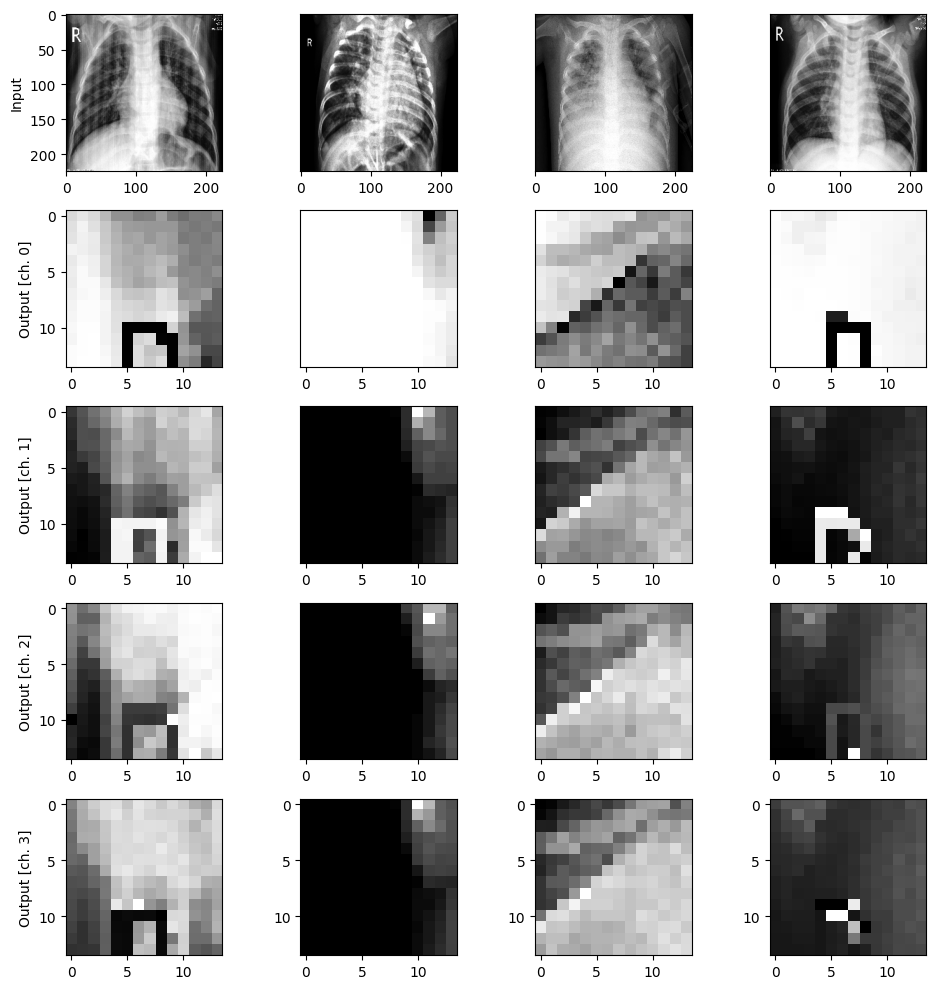

In [15]:
n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()

In [16]:
def MyModel():
    """Initializes and returns a custom Keras model
    which is ready to be trained."""
    model = keras.models.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(10, activation="softmax")
    ])

    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

In [17]:
q_model = MyModel()

q_history = q_model.fit(
    q_train_images,
    train_labels,
    validation_data=(q_test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/5
63/63 - 0s - loss: 1.0794 - accuracy: 0.5100 - val_loss: 1.1667 - val_accuracy: 0.3939 - 465ms/epoch - 7ms/step
Epoch 2/5
63/63 - 0s - loss: 0.8361 - accuracy: 0.6096 - val_loss: 1.2360 - val_accuracy: 0.5455 - 92ms/epoch - 1ms/step
Epoch 3/5
63/63 - 0s - loss: 0.8209 - accuracy: 0.6454 - val_loss: 1.1153 - val_accuracy: 0.5455 - 107ms/epoch - 2ms/step
Epoch 4/5
63/63 - 0s - loss: 0.7801 - accuracy: 0.6494 - val_loss: 1.0572 - val_accuracy: 0.5758 - 95ms/epoch - 2ms/step
Epoch 5/5
63/63 - 0s - loss: 0.7605 - accuracy: 0.6614 - val_loss: 1.1044 - val_accuracy: 0.5909 - 95ms/epoch - 2ms/step


In [18]:
c_model = MyModel()

c_history = c_model.fit(
    train_images,
    train_labels,
    validation_data=(test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/5
63/63 - 1s - loss: 9.7341 - accuracy: 0.7291 - val_loss: 12.1500 - val_accuracy: 0.6667 - 1s/epoch - 18ms/step
Epoch 2/5
63/63 - 1s - loss: 6.9165 - accuracy: 0.7928 - val_loss: 18.7625 - val_accuracy: 0.6364 - 773ms/epoch - 12ms/step
Epoch 3/5
63/63 - 1s - loss: 4.9912 - accuracy: 0.8685 - val_loss: 22.4016 - val_accuracy: 0.6061 - 796ms/epoch - 13ms/step
Epoch 4/5
63/63 - 1s - loss: 3.8871 - accuracy: 0.8964 - val_loss: 5.9721 - val_accuracy: 0.8333 - 1s/epoch - 17ms/step
Epoch 5/5
63/63 - 1s - loss: 4.5191 - accuracy: 0.8884 - val_loss: 27.0756 - val_accuracy: 0.6667 - 672ms/epoch - 11ms/step


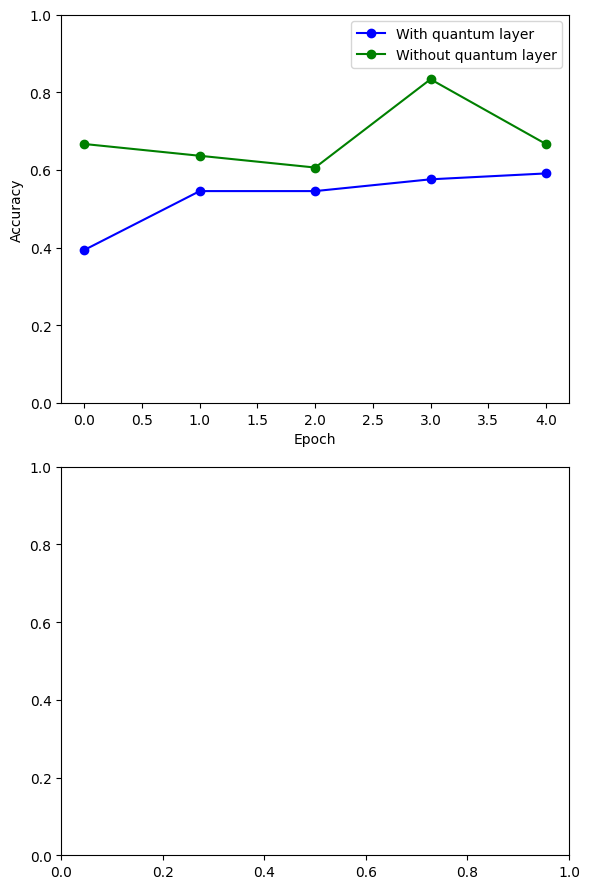

In [19]:
import matplotlib.pyplot as plt

#plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

plt.tight_layout()
plt.show()